<a href="https://colab.research.google.com/github/Akshayalakshmi-P/RFSoC-Board-Measurement-Post-Processing/blob/main/Tx2_Rx2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project Report**




##**Formulation**
RFSOC board 4-Tx 2-Rx Data Measurement & Post-processing


1.   The primary goal of this project was to process wideband OFDM signals captured using a 4-Tx 2-Rx Xilinx RFSoC board.

2. The objective was to analyze these signals under varying angles of arrival (AOAs), perform time synchronization and frequency-domain transformation.and finally estimate and equalize the wireless channel to recover the transmitted data.



##**Appraoch & Design**


1.   **Real-Time Data Acquisition:**
Captured I/Q baseband data in real time using the Xilinx RFSoC board with a 4-Tx and 2-Rx antenna configuration. Measurements were collected for multiple Angles of Arrival (AOAs).

2. **Spectral Analysis:**
Computed and plotted the overlaid spectra of all received signals to visualize bandwidth occupancy and consistency across AOAs. This helped identify the active frequency range of the OFDM signal.

3. **Time Synchronization:**
Performed circular correlation between a known transmitted OFDM symbol and the received signal stream. The peak in the correlation metric indicated the correct symbol alignment offset.

4. **Frequency Domain Transformation:**
Applied Fast Fourier Transform (FFT) and performed FFT shift (fftshift) to move the DC subcarrier to the center, facilitating better constellation visualization and subcarrier access.

5. **Channel Estimation and Equalization:**
Estimated the channel frequency response using known transmitted data and applied MMSE (Minimum Mean Square Error) equalization to compensate for multipath fading and channel distortions.

6. **Constellation Analysis:**
Plotted the constellation diagrams before and after equalization to compare the raw received signal against the channel-equalized signal. Post-EQ diagrams showed clear clustering of QAM symbols, demonstrating the effectiveness of the equalization step.



##**Implementation**

###    RFSOC board measurement:

In [ ]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

Saving WhatsApp Image 2025-05-15 at 16.26.30_3c5ec44a.jpg to WhatsApp Image 2025-05-15 at 16.26.30_3c5ec44a (1).jpg
Saving WhatsApp Image 2025-05-15 at 16.26.30_571c8b53.jpg to WhatsApp Image 2025-05-15 at 16.26.30_571c8b53.jpg
Saving WhatsApp Image 2025-05-15 at 16.26.30_824750eb.jpg to WhatsApp Image 2025-05-15 at 16.26.30_824750eb.jpg
Saving WhatsApp Image 2025-05-15 at 16.26.31_0ac43975.jpg to WhatsApp Image 2025-05-15 at 16.26.31_0ac43975.jpg


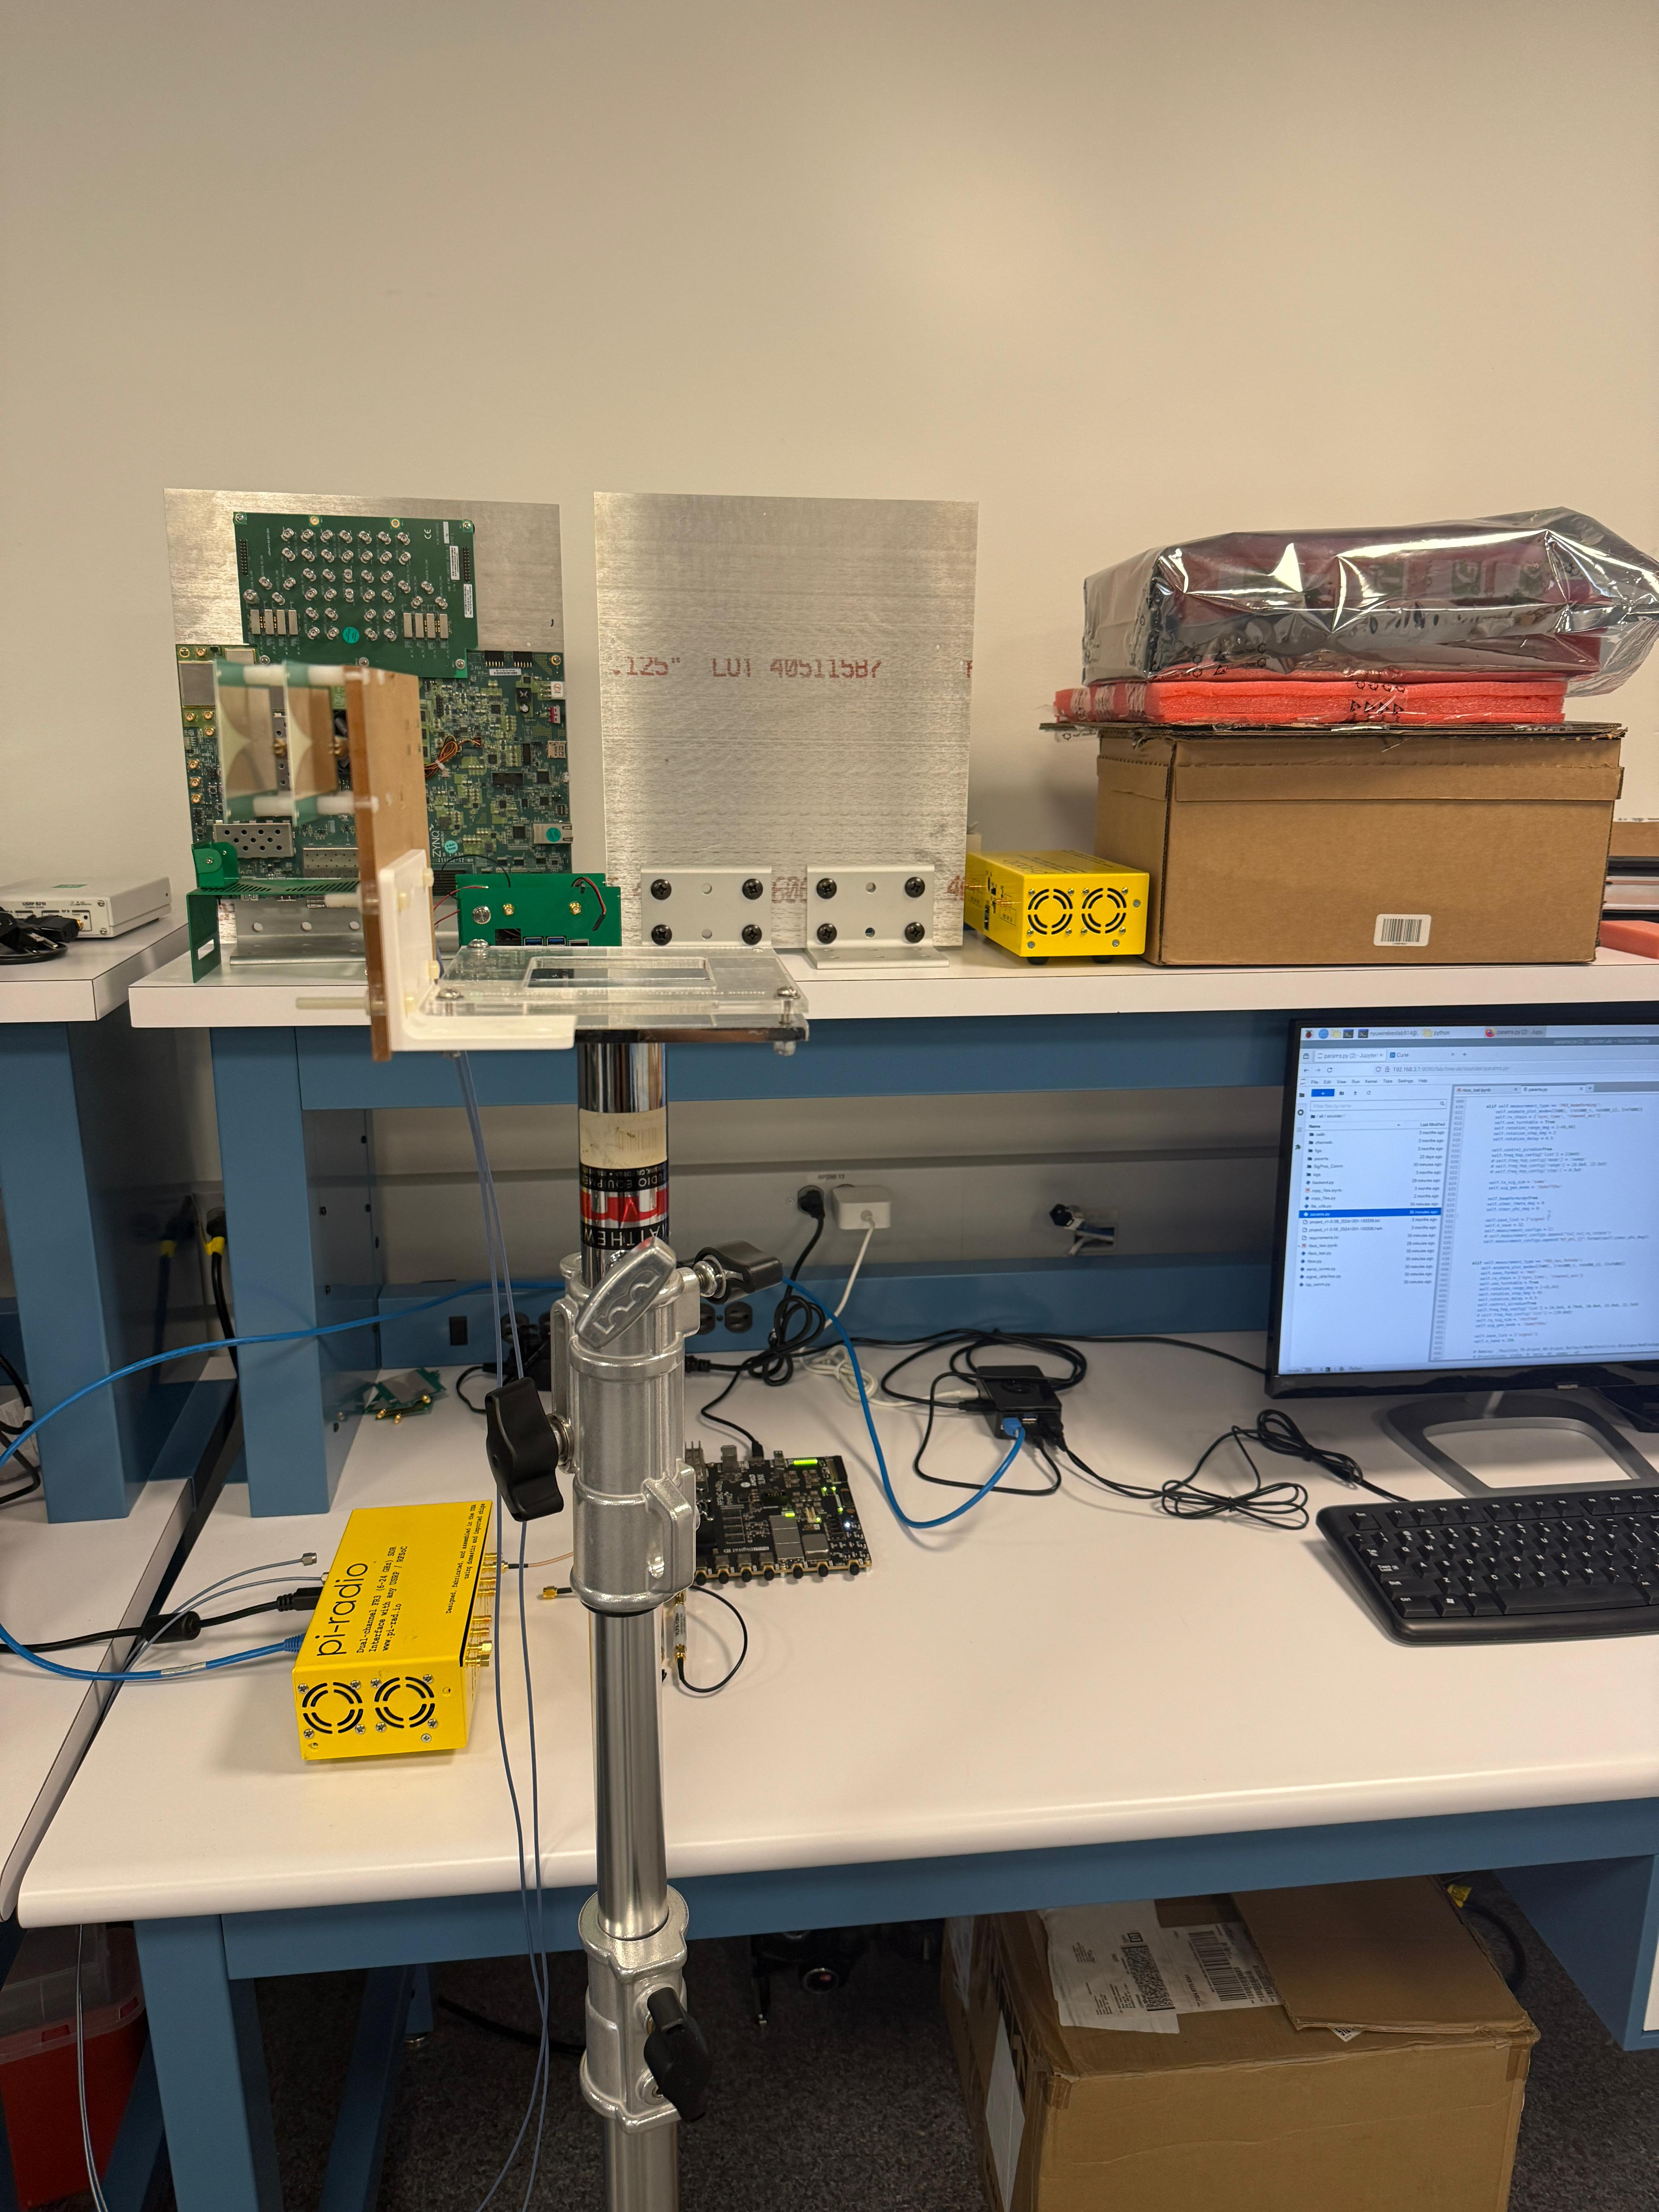

In [ ]:
Image('WhatsApp Image 2025-05-15 at 16.26.30_3c5ec44a.jpg', width=300)

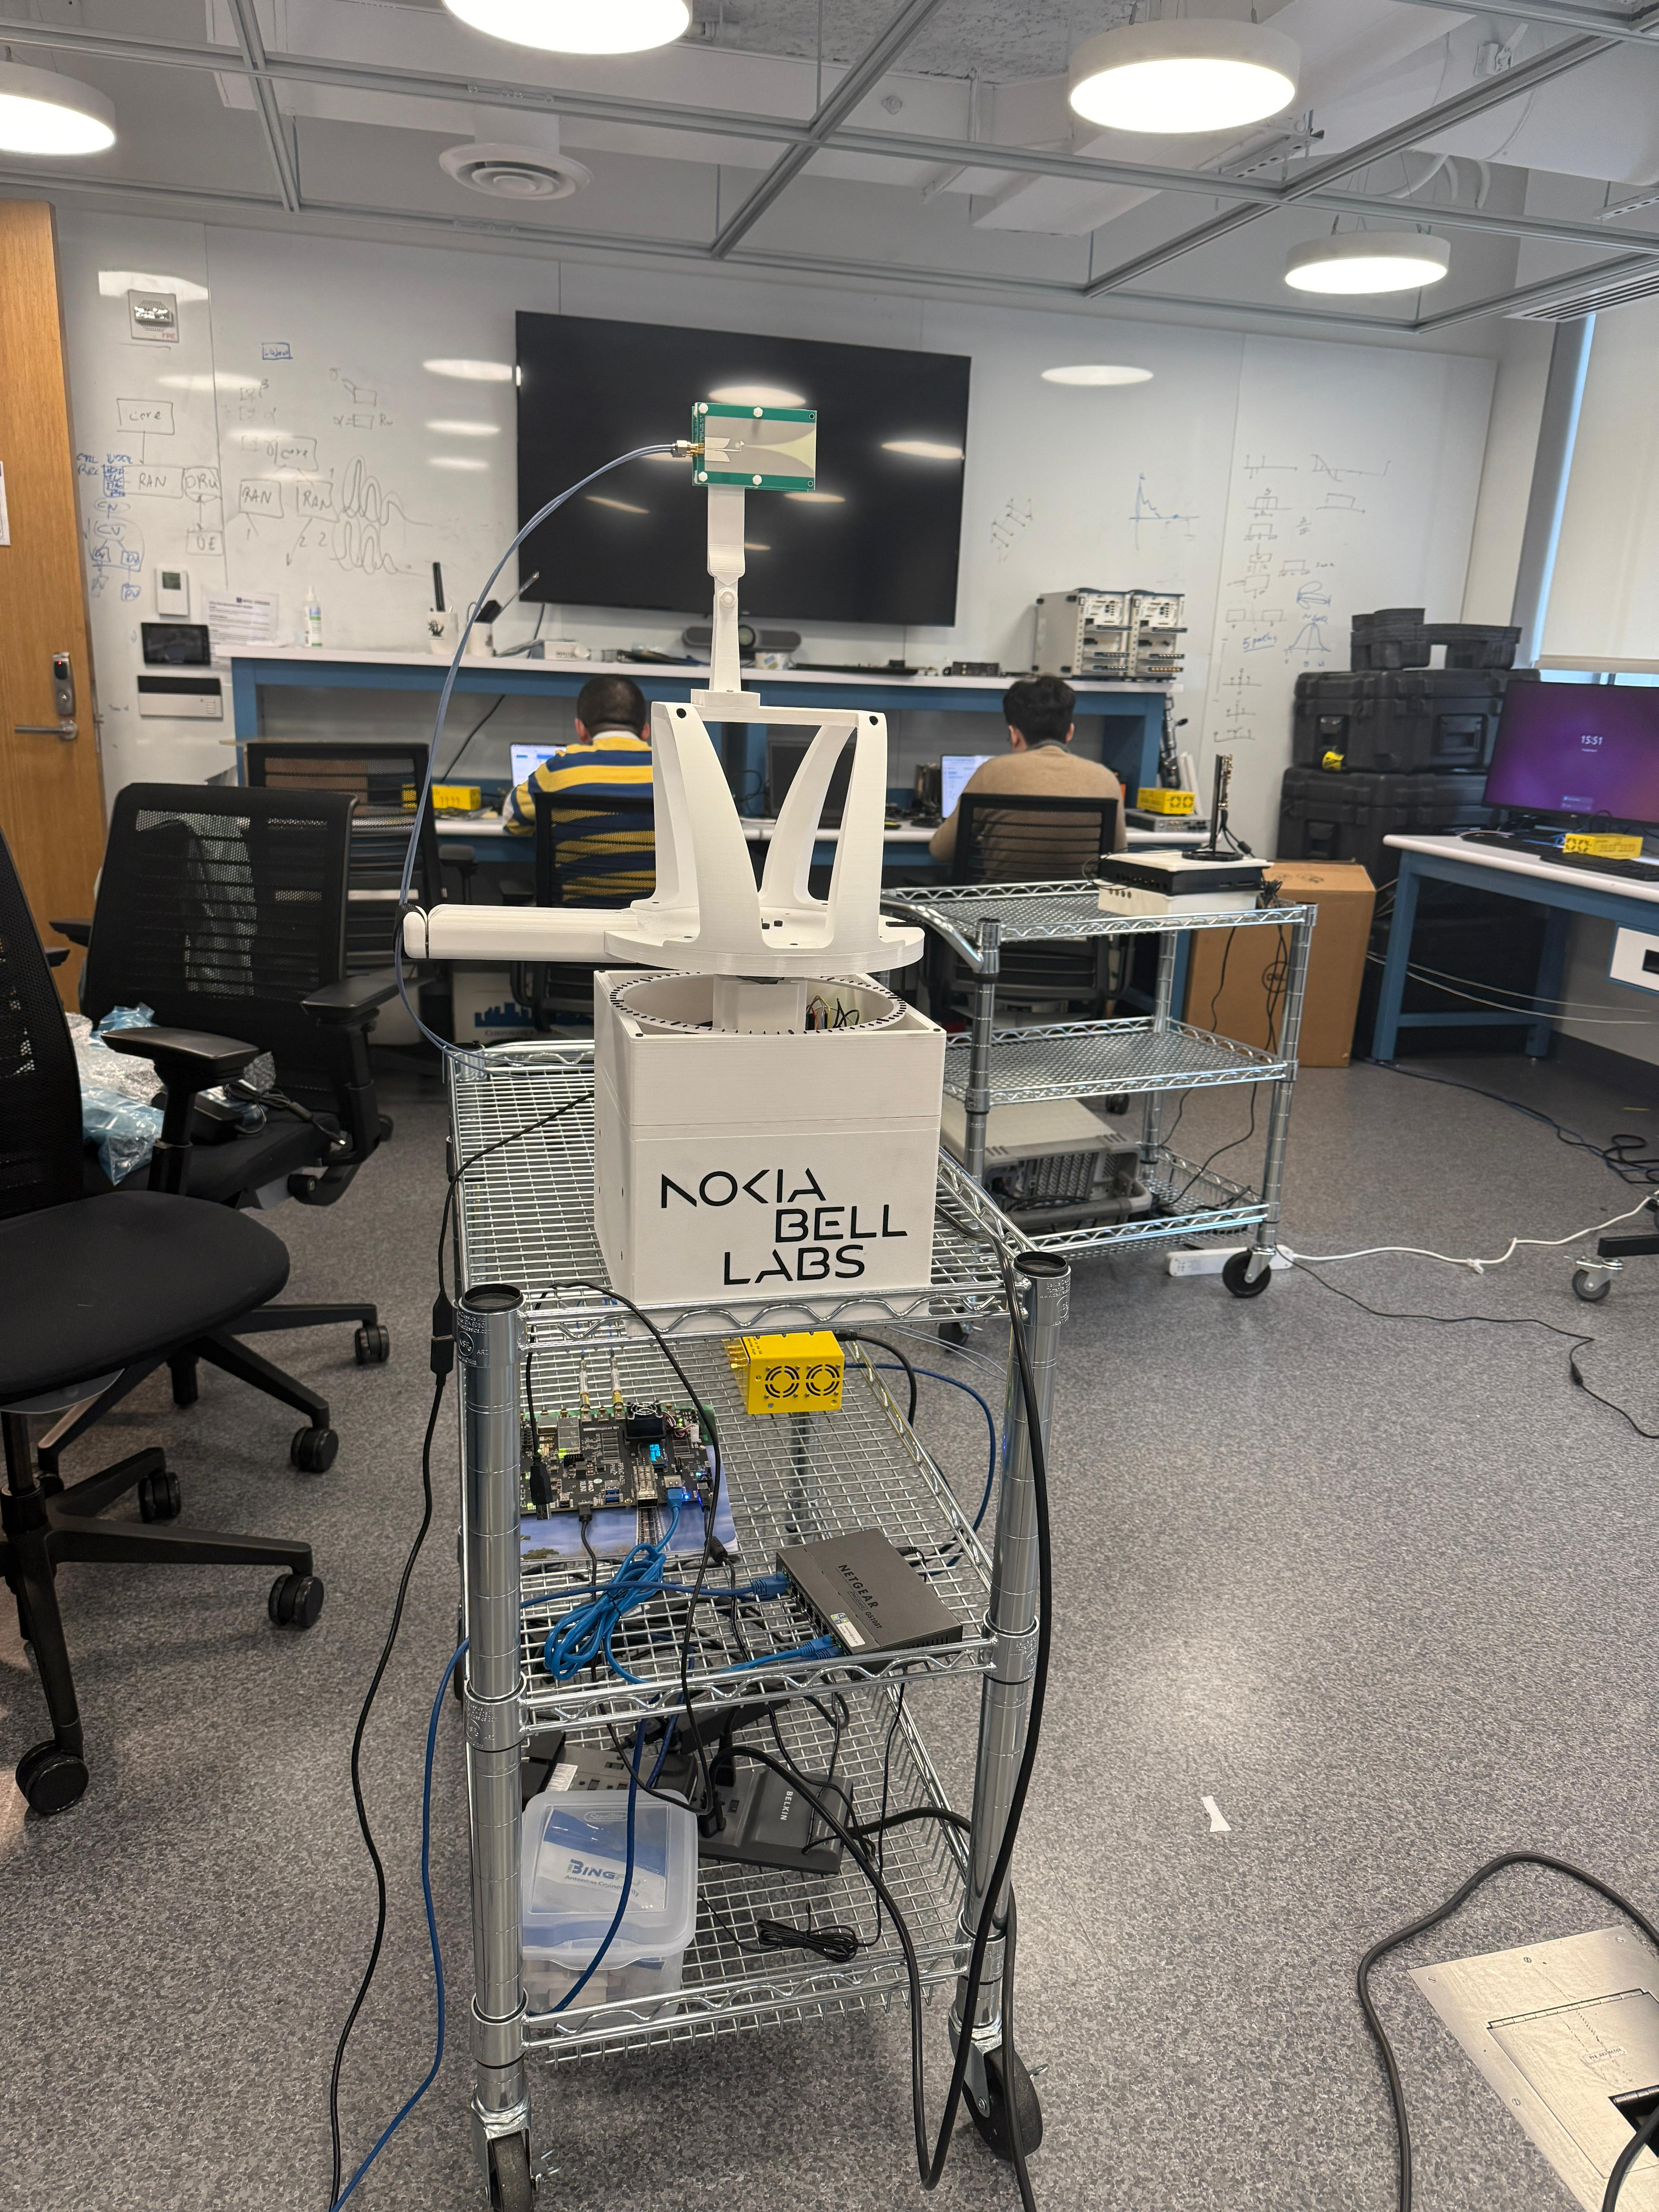

In [ ]:
Image('WhatsApp Image 2025-05-15 at 16.26.30_824750eb.jpg', width=300)

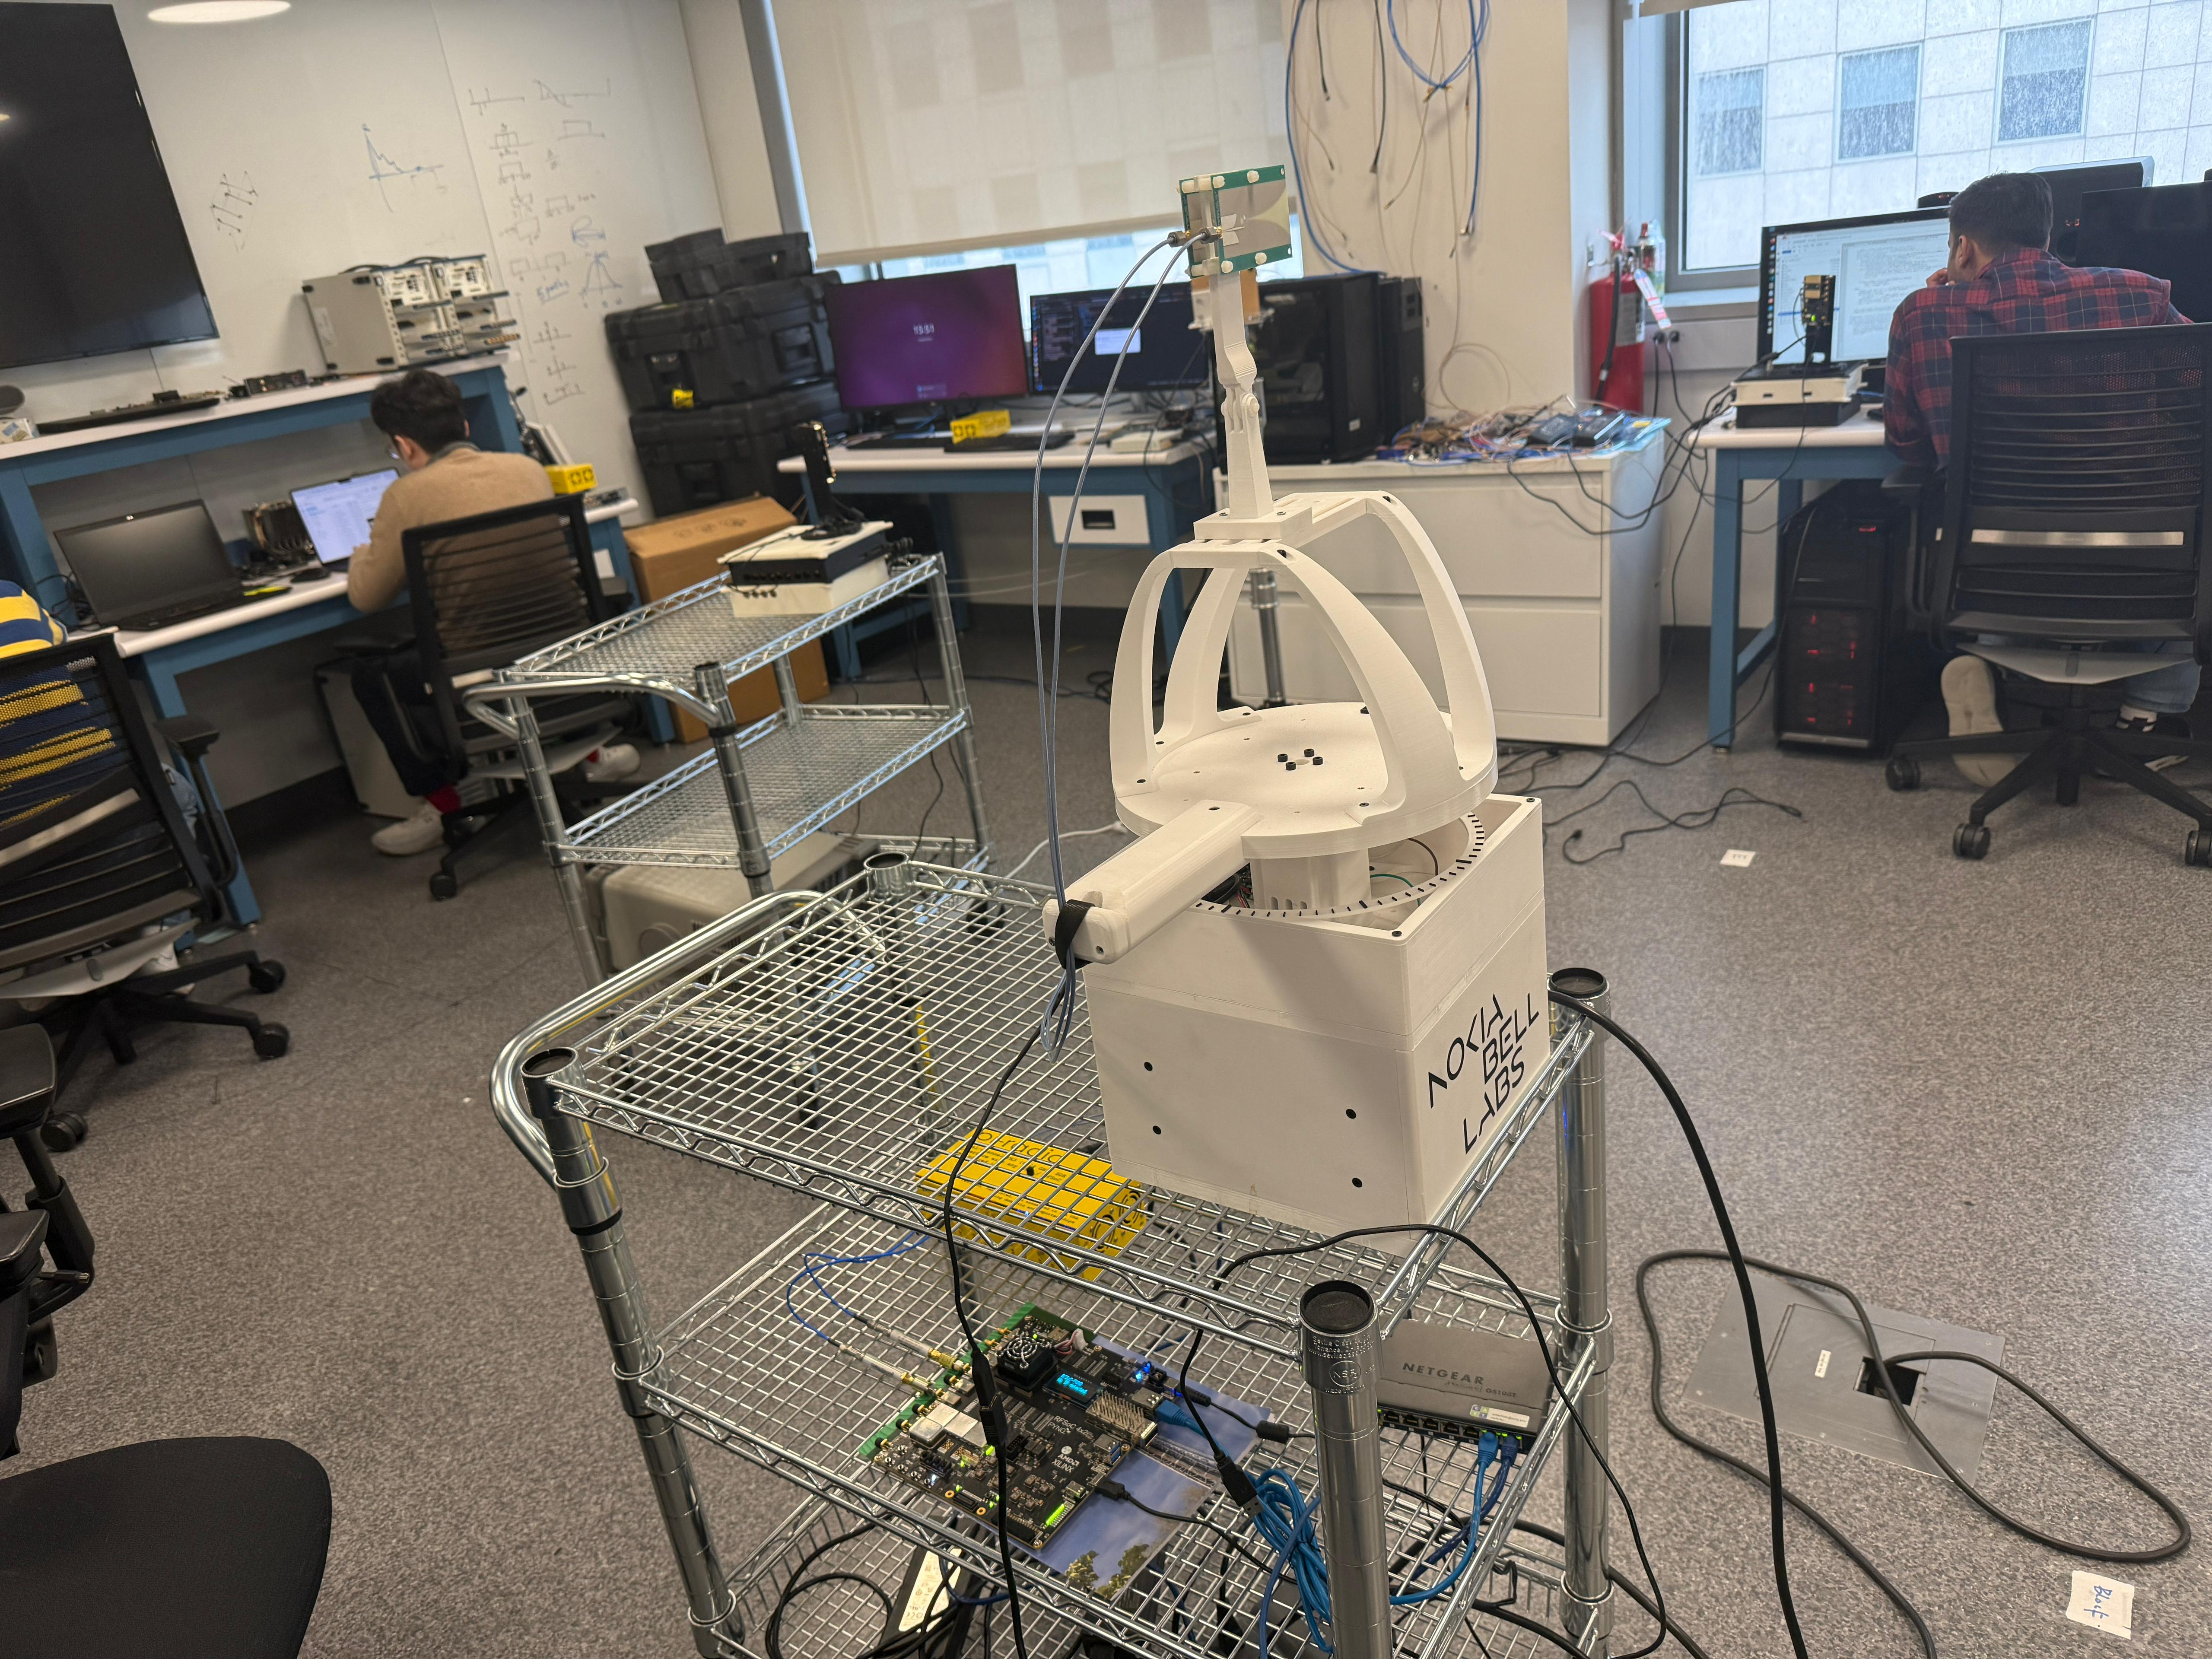

In [ ]:
Image('WhatsApp Image 2025-05-15 at 16.26.31_0ac43975.jpg', width=500)

###    Overlayed Spectrum plot for different AOAs:

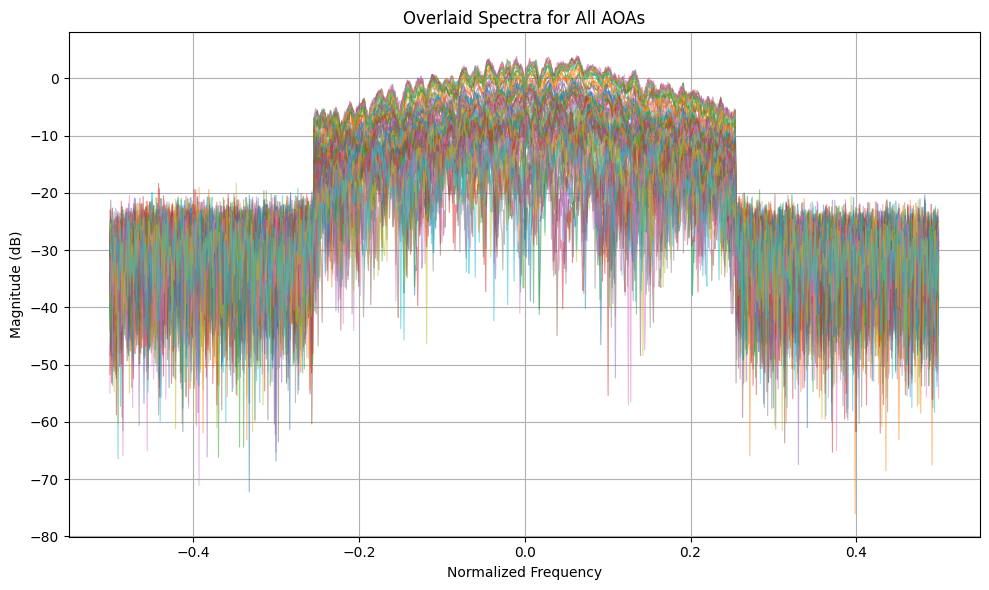

In [ ]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt

zip_path = '/Wireless Comm Project/Beamforming FFT.zip'

with zipfile.ZipFile(zip_path, 'r') as z:

    files = sorted(f for f in z.namelist() if f.endswith('.npz'))

    plt.figure(figsize=(10, 6))

    # Overlay each file's spectrum
    for file in files:
        data = np.load(z.open(file))

        # Choose the rxtd key if present, otherwise the first array
        key = next((k for k in data.files if k.startswith('rxtd')), data.files[0])
        rxtd = data[key]
        snapshot = rxtd[0]    # first snapshot
        signal = snapshot[0] + 1j * snapshot[1]

        N = signal.size
        fft_vals = np.fft.fftshift(np.fft.fft(signal))
        mag_db = 20 * np.log10(np.abs(fft_vals) + 1e-12)
        freq = np.fft.fftshift(np.fft.fftfreq(N))

        plt.plot(freq, mag_db, linewidth=0.8, alpha=0.5)

    plt.xlabel('Normalized Frequency')
    plt.ylabel('Magnitude (dB)')
    plt.title('Overlaid Spectra for All AOAs')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


###    Time synchronization & Constellation diagram plotting:

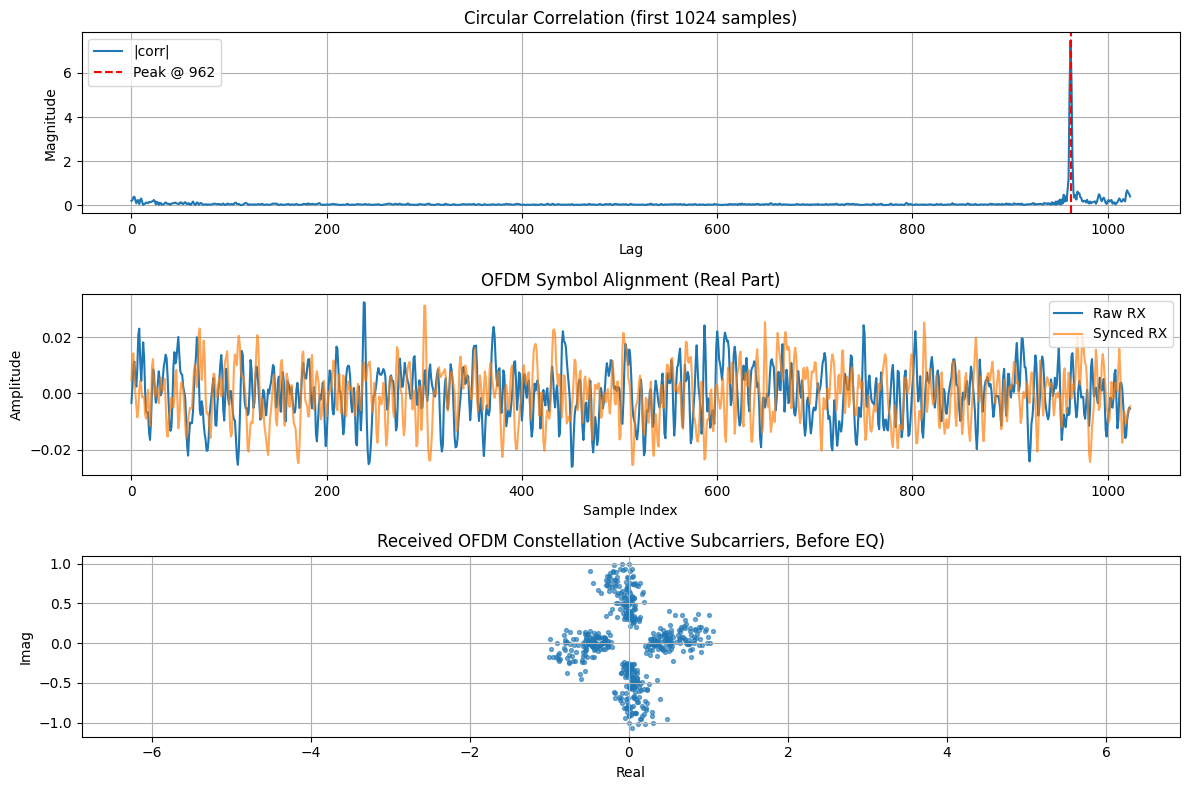

In [ ]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt

# 1) Load Tx and Rx data (With AOA of -2 degree)
zip_path = '/Wireless Comm Project/Beamforming FFT.zip'
with zipfile.ZipFile(zip_path, 'r') as z:
    fname = next(f for f in z.namelist() if f.split('/')[-1].startswith('-2_') and f.endswith('.npz'))
    data = np.load(z.open(fname))
    txtd = data['txtd']
    tx_sig = txtd[0,0,:] + 1j*txtd[0,1,:]  # one OFDM symbol
    rxtd = data['rxtd_10.0']
    rx_all = (rxtd[:,0,:] + 1j*rxtd[:,1,:]).reshape(-1)

# 2) Circular correlation (limit to one symbol period)
N = len(tx_sig)
tx_pad = np.zeros(len(rx_all), dtype=complex)
tx_pad[:N] = tx_sig
corr = np.fft.ifft(np.conj(np.fft.fft(tx_pad)) * np.fft.fft(rx_all))
offset = np.argmax(np.abs(corr[:N]))

# 3) Align received buffer
rx_sync = np.roll(rx_all, -offset)

# 4) Extract OFDM symbol (realignment)
sym_sync = rx_sync[:N]

# 5) FFT to get subcarriers
S_rx = np.fft.fftshift(np.fft.fft(sym_sync))
S_tx = np.fft.fftshift(np.fft.fft(tx_sig))

# 6) Identify active carriers (where Tx carried non-zero pilots/data)
active = np.abs(S_tx) > 1e-6

# 7) Plotting
plt.figure(figsize=(12, 8))

# a) Correlation metric
plt.subplot(3,1,1)
plt.plot(np.abs(corr[:N]), label='|corr|')
plt.axvline(offset, color='r', linestyle='--', label=f'Peak @ {offset}')
plt.title('Circular Correlation (first 1024 samples)')
plt.xlabel('Lag')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)

# b) Alignment raw vs synced (real part)
plt.subplot(3,1,2)
plt.plot(rx_all[:N].real, label='Raw RX')
plt.plot(sym_sync.real, label='Synced RX', alpha=0.7)
plt.title('OFDM Symbol Alignment (Real Part)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# c) Constellation before EQ, active only
plt.subplot(3,1,3)
plt.scatter(S_rx[active].real, S_rx[active].imag, s=8, alpha=0.6)
plt.title('Received OFDM Constellation (Active Subcarriers, Before EQ)')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.axis('equal')
plt.grid(True)

plt.tight_layout()
plt.show()



###    Channel Estimation & Equalization:

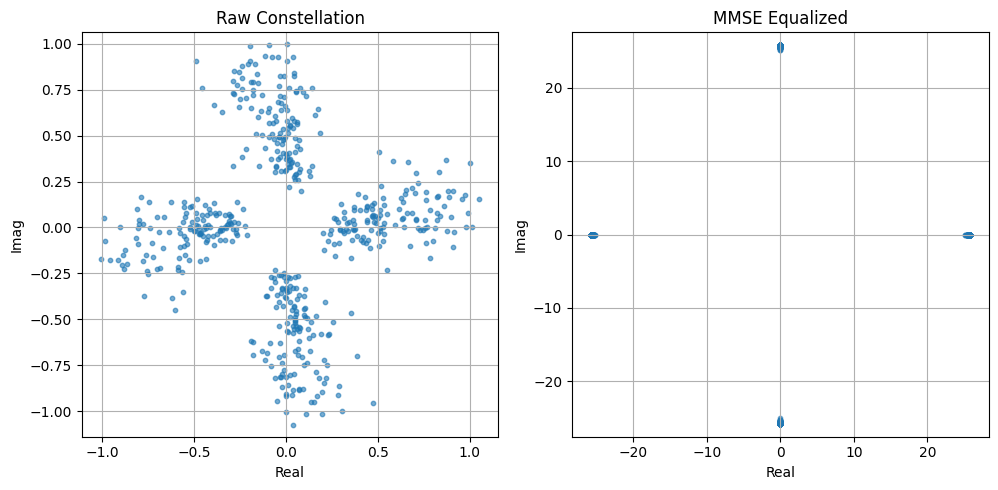

In [ ]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt

zip_path = '/Wireless Comm Project/Beamforming FFT.zip'
with zipfile.ZipFile(zip_path, 'r') as z:
    fname = next(f for f in z.namelist()
                 if f.split('/')[-1].startswith('-2_') and f.endswith('.npz'))
    data = np.load(z.open(fname))
    # TX OFDM symbol (single snapshot)
    txtd = data['txtd']
    tx_sig = txtd[0,0,:] + 1j*txtd[0,1,:]

    # RX buffer flattened (32 repeats)
    rxtd = data['rxtd_10.0']       )
    rx_all = (rxtd[:,0,:] + 1j*rxtd[:,1,:]).reshape(-1)

# 1) Sync via circular correlation (limit to one OFDM period)
N = len(tx_sig)
L = len(rx_all)
tx_pad = np.zeros(L, dtype=complex)
tx_pad[:N] = tx_sig
corr = np.fft.ifft(np.conj(np.fft.fft(tx_pad)) * np.fft.fft(rx_all))
offset = int(np.argmax(np.abs(corr[:N])))
rx_sync = np.roll(rx_all, -offset)

# 2) Extract one OFDM symbol and FFT
symbol = rx_sync[:N]
S_rx = np.fft.fftshift(np.fft.fft(symbol))
S_tx = np.fft.fftshift(np.fft.fft(tx_sig))

# 3) Identify active subcarriers and noise bins
active = np.abs(S_tx) > 1e-6
noise_bins = ~active

# 4) Channel estimation (ZF) per subcarrier
H_est = np.zeros_like(S_rx)
H_est[active] = S_rx[active] / (S_tx[active] + 1e-12)

# 5) Noise & tx power estimates
noise_var = np.mean(np.abs(S_rx[noise_bins])**2)
tx_var = np.mean(np.abs(S_tx[active])**2)

# 6) MMSE equalization: Wiener filter
W_mmse = np.zeros_like(H_est)
W_mmse[active] = np.conj(H_est[active]) / (np.abs(H_est[active])**2 + noise_var/tx_var)
S_eq_mmse = W_mmse * S_rx

# 7) Plot constellations
plt.figure(figsize=(10, 5))

# Raw constellation
plt.subplot(1,2,1)
plt.scatter(S_rx[active].real, S_rx[active].imag, s=10, alpha=0.6)
plt.title('Raw Constellation')
plt.xlabel('Real'); plt.ylabel('Imag')
plt.axis('equal'); plt.grid(True)

# MMSE equalized
plt.subplot(1,2,2)
plt.scatter(S_eq_mmse[active].real, S_eq_mmse[active].imag, s=10, alpha=0.6)
plt.title('MMSE Equalized')
plt.xlabel('Real'); plt.ylabel('Imag')
plt.axis('equal'); plt.grid(True)

plt.tight_layout()
plt.show()




##**Evaluation & Interpretation**


*   In this project, we have successfully captured real-world RF data using the RFSoC board and implemented a full signal processing chain to analyze and recover the transmitted signal.

*   The time synchronization using circular correlation clearly identified the OFDM symbol boundary, with a sharp peak confirming the timing offset.

* The overlaid spectra showed consistent bandwidth usage across all AOAs, validating the uniformity of the transmission setup.

* The constellation plots before equalization displayed significant symbol dispersion due to channel effects, while post-equalization constellations showed clean and distinct QAM clusters, indicating effective channel estimation and MMSE equalization.

* However, the post-equalization constellation appeared overly ideal, suggesting that the channel estimation or equalization process may have oversimplified real-world imperfections. This raises the possibility that certain channel impairments might have been unintentionally compensated or overlooke

* Our method robustly handled signals from varying AOAs, demonstrating the generalizability of the pipeline and its potential application in beamforming or direction-of-arrival (DoA) estimation tasks.

